## Data Generation

In this notebook, we simulate a simple small microbial community which undergoes perturbations with antibiotic at varying concentrations and timepoints. Our is to then be able to predict community evolution as a function of timecourse perturbation from this system using our VAE-MLP model. 

In [2]:
# Begin by importing 
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt 
from tqdm.notebook import trange, tqdm 

In [6]:
gamma = np.array([[ 0.02044936,  0.13704489, -2.352834  ],
                  [-0.55130581, 1.5302831,   1.17962592],
                  [-2.1573149 ,  0.77067634, -0.55497408]])

print(np.around(gamma,2))

[[ 0.02  0.14 -2.35]
 [-0.55  1.53  1.18]
 [-2.16  0.77 -0.55]]


For our model, we'll use our previous variation on gLV except now we'll include a death term proportional to the concentration of antibiotic: 

$$
\dfrac{dp_i}{dt} = \mu_i\,p_i\,\left(1-p_i-\dfrac{\sigma}{1+\sum \gamma_{ij}^+ p_j} + \sum \gamma_{ij}^-p_j\right) - \kappa_i \, a p_i
$$

Where $a$ is th concentration of antibiotic and $\kappa_i$ is the strength of the antibiotic and varies between species. In practice we'll draw all of these values at random. The antibiotic dynamics are straight forward just simply decay dynamics:

$$
\dfrac{d a}{dt} = -D a
$$

In [321]:
def antibiotic(a0, t, t0, D):
    """Return the antibiotic concentration for a system at a given time point t and offset t0"""
    if t < t0:
        return a0*np.exp(2*D*(t-t0))
    else:
        return a0*np.exp(-D*(t-t0))

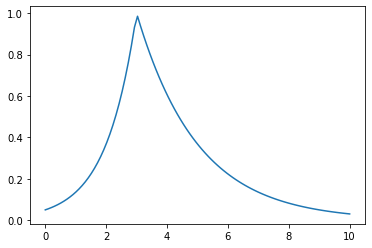

In [322]:
a0 = 1.0
t = 10
t0 = 3
D = 0.5
antibiotic(a0, t, t0, D)

ants = []
t_range = np.linspace(0, 10, 100)
for t in t_range:
    ants.append(antibiotic(a0, t, t0, D))
    
plt.plot(t_range, ants)

In [323]:
def multi_species_model(p,t,n,Gamma, sigma, mu, kappa, D, a0, t_offset):

    # We must construct a list of n elements, each corresponding to the growth derivative of each species    
    dpdt = np.zeros(n)
    a = antibiotic(a0, t, t_offset, D)
    
    # Pull off all positive interactions and negative interactions
    Gamma_pos = Gamma*(Gamma > 0)
    Gamma_neg = Gamma*(Gamma < 0)
    
    # Compute the current value of the net positive and negative interaction terms
    gamma_pos = Gamma_pos @ p
    gamma_neg = Gamma_neg @ p
    
    # Compute the derivative term in vectorized form
    dpdt = mu * p * ( np.ones(n) - p - sigma/(np.ones(n)+gamma_pos)  + gamma_neg ) + kappa*a*p
    
    return dpdt

Now we'll simulate a three member community: 

In [331]:
N = 3
mu = np.array([0.54585316, 0.67292919, 0.63519015])
gamma = np.array([[ 0.02044936,  0.13704489, -2.352834  ],
                  [-0.55130581, 1.5302831,   1.17962592],
                  [-2.1573149 ,  0.77067634, -0.55497408]])
sigma = 0.05
p0 = 0.05*np.ones(N)
time_range = np.linspace(0,40,50)

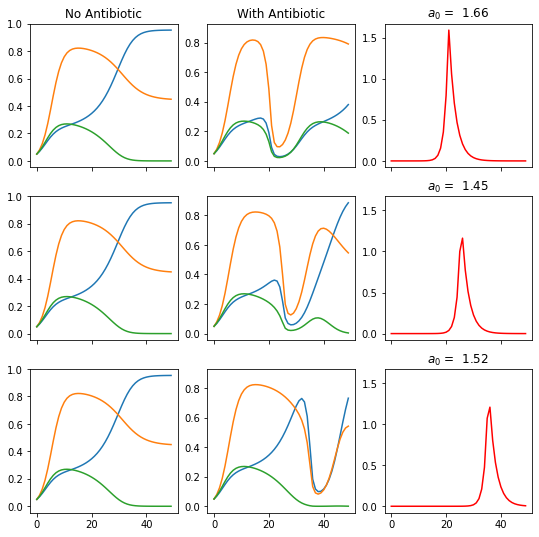

In [376]:
num_sim = 3
fig, axs = plt.subplots(num_sim,3,figsize = (9,3*num_sim), sharex = True, sharey = "col");

for i, ax in enumerate(axs):
    
    ax1, ax2, ax3 = ax
    
    a0 = np.random.uniform(1.0, 2.0)
    kappa = -1.0*np.ones(N)
    D = 0.5
    t_offset = np.random.uniform(10,30)

    sol = odeint(multi_species_model,  p0, time_range, args = (N,gamma, sigma, mu, kappa, D, a0, t_offset))
    species = sol[:,0:N]

    ants = []
    for t in time_range:
        ants.append(antibiotic(a0, t, t_offset, D))


    ax2.plot(species)
    ax3.plot(ants, color = 'red')
    ax3.set_title(rf"$a_0$ =  {np.around(a0,2)}")

    a0 = 0
    sol = odeint(multi_species_model,  p0, time_range, args = (N,gamma, sigma, mu, kappa, D, a0, t_offset))
    species = sol[:,0:N]
    ax1.plot(species)
    
    
    if i == 0:
        ax1.set_title("No Antibiotic")
        ax2.set_title("With Antibiotic")


plt.show()

Let's now generate a dataset for this system:

In [363]:
num_sims = 5000

sols = []
params = []
for i in trange(num_sims):
    
    a0 = np.random.uniform(1.0, 2.0)
    t_offset = np.random.uniform(10,30)
    
    
    sol = odeint(multi_species_model,  p0, time_range, args = (N,gamma, sigma, mu, kappa, D, a0, t_offset))
    species = sol[:,0:N]
    
    param = np.array([a0, t_offset])
    params.append(param)
    
    sols.append(species)
    
sols = np.array(sols).swapaxes(1,2)
print(sols.shape)

  0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 3, 50)


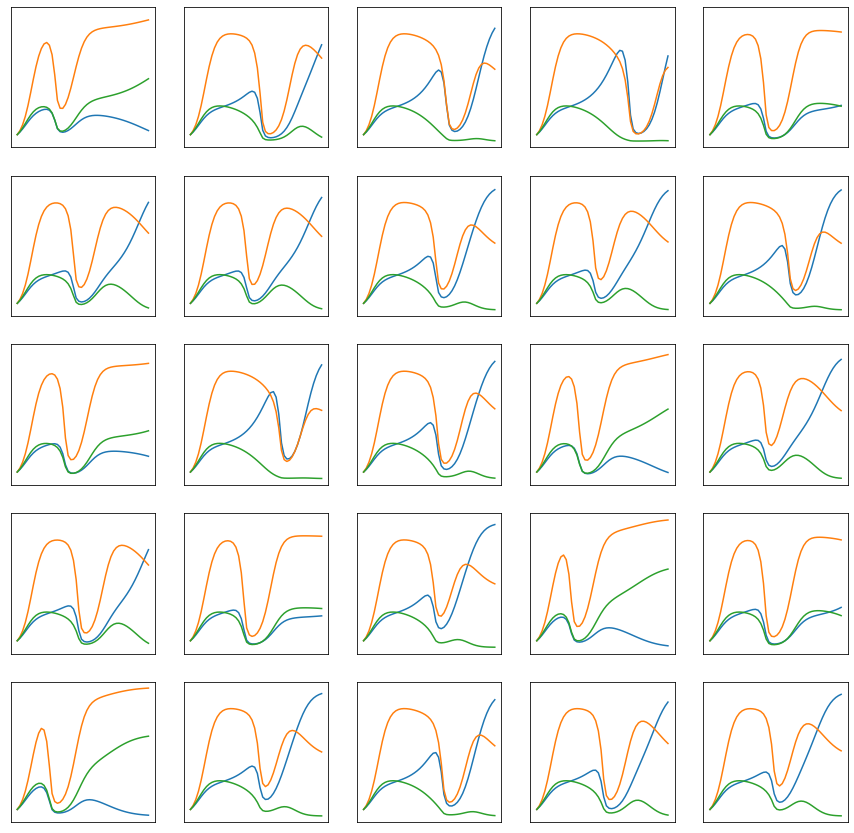

In [365]:
num_plots = 5
fig, axs = plt.subplots(num_plots, num_plots, figsize = (15,15), sharex = True, sharey = True)

for i in range(num_plots**2):
    ax = axs.flatten()[i]
    
    ax.plot(sols[i].T)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [366]:
params = np.array(params)

In [369]:
# Save the data
np.save('./data/curves.npy', sols)

In [370]:
np.save('./data/labels.npy', params)